Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from typing import List, Optional
from anytree import Node, RenderTree

In [4]:
X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])

query_pt = ([7, 4])

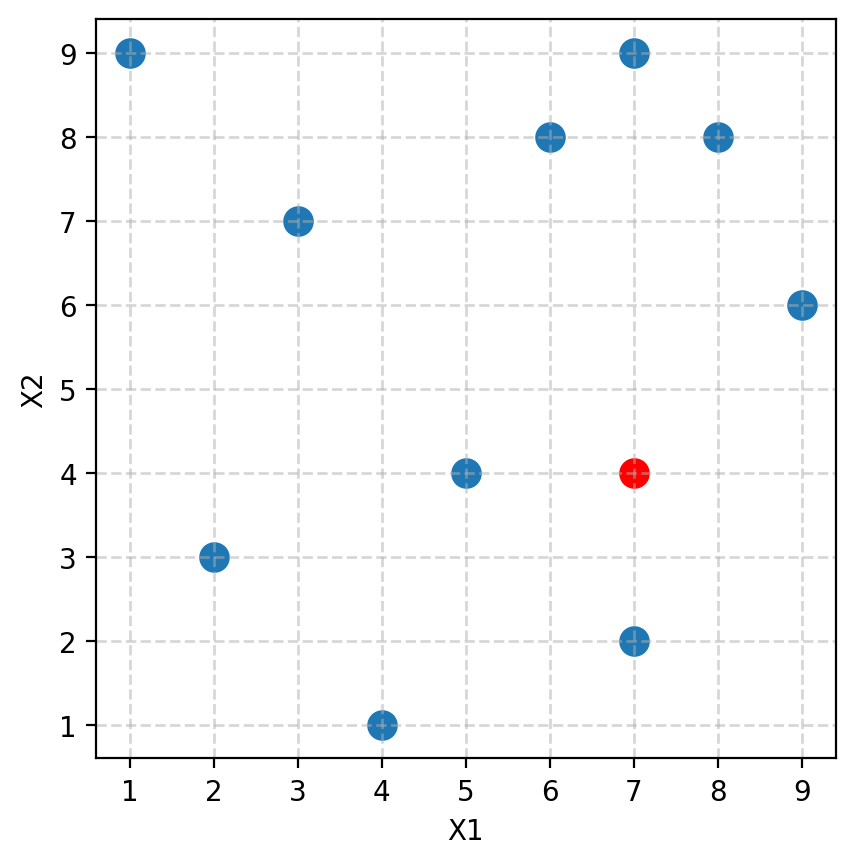

In [5]:
def plot_dataset():
    plt.scatter(X[:, 0], X[:, 1], s=100)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5)
    plt.xticks(np.arange(min(X[:, 0]), max(X[:, 0])+1, 1))
    plt.yticks(np.arange(min(X[:, 1]), max(X[:, 1])+1, 1))
    
    plt.scatter(query_pt[0], query_pt[1], color='red', s=100)
    

plot_dataset()
    

KNN from Sci-kit learn

In [6]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(X)
distances, indices = nbrs.kneighbors([query_pt])

In [7]:
indices, X[indices], distances

(array([[4, 6]], dtype=int64),
 array([[[5, 4],
         [7, 2]]]),
 array([[2., 2.]]))

Using the naive KNN approach

In [8]:
def pairwise_dist(x: np.ndarray, y: np.ndarray) -> float:
    """
        x: numpy array of shape(d, )
        y: numpy array of shape(d, )
        
        returns the euclidean distance between two d dimensionsal arrays x and y
    """
    return np.sqrt(np.sum((x-y)**2))
    

In [10]:
def distance_vector(X: np.ndarray, y:np.ndarray) -> np.ndarray:
    """
        X: numpy array of shape(n, d)
        query_pt: numpy array of shape(d, )
        
        returns the distance of query_pt from all the points in X
    """
    
    n, d = X.shape
    distances = np.zeros(n)
    for i in range(n):
        distances[i] = pairwise_dist(X[i], query_pt)
    return distances

In [11]:
distances = distance_vector(X, query_pt)

In [12]:
distance_table = pd.DataFrame({
    "Point" : X.tolist(),
    "Distance" : distances
})

In [13]:
distance_table

,Point,Distance
0,"[1, 9]",7.810250
1,"[2, 3]",5.099020
2,"[4, 1]",4.242641
3,"[3, 7]",5.000000
4,"[5, 4]",2.000000
5,"[6, 8]",4.123106
6,"[7, 2]",2.000000
7,"[8, 8]",4.123106
8,"[7, 9]",5.000000
9,"[9, 6]",2.828427


We can see that the minimum distances for the points [5,4] and [7,2]. There are the nearest neighbours and it is the same result as obtained with the sklearn implementation

In [14]:
distance_table.sort_values(by=['Distance'])

,Point,Distance
4,"[5, 4]",2.000000
6,"[7, 2]",2.000000
9,"[9, 6]",2.828427
5,"[6, 8]",4.123106
7,"[8, 8]",4.123106
2,"[4, 1]",4.242641
3,"[3, 7]",5.000000
8,"[7, 9]",5.000000
1,"[2, 3]",5.099020
0,"[1, 9]",7.810250


Using KD trees

In [15]:
class KDNode:
    def __init__(self, point=None, points=None, dim=None, left=None, right=None):
        """
            point: The coordinate of the point represented by this node
            left: The left child
            right: The right child
            dim: The dimension used to split the data
            points: The set of points stored at the leaf node
        """
        self.point = point
        self.points = points
        self.dim = dim
        self.left = left
        self.right = right

    def __repr__(self):
        return f"KDNode(point={self.point}, dim={self.dim})"

class KDTree:
    def __init__(self, min_samples_split=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.X = None
        self.n_dimensions = None
        
    def build(self, X: np.ndarray):
        """
        Builds the KD-tree from input data
        
        Parameters:
        -----------
        X : np.ndarray
            Input data of shape (n_samples, n_features)
        """
        self.X = X
        self.n_dimensions = X.shape[1]
        self.root = self.split(X)
        
    def fit(self, X: np.ndarray):
        """
        Alias for build method to maintain consistency with sklearn-style interface
        """
        return self.build(X)
        
    def split(self, X: np.ndarray, depth: int = 0) -> Optional[KDNode]:
        if len(X) == 0:
            return None
            
        if len(X) < self.min_samples_split:
            return KDNode(point=X[0], points=X, dim=None)
        
        dim = depth % self.n_dimensions
        
        sorted_idx = X[:, dim].argsort()
        X_sorted = X[sorted_idx]
        
        median_idx = len(X_sorted) // 2
        
        median_val = X_sorted[median_idx, dim]
        
        left_mask = X_sorted[:, dim] < median_val
        right_mask = X_sorted[:, dim] > median_val
        median_mask = X_sorted[:, dim] == median_val
        
        median_points = X_sorted[median_mask]
        median_split = len(median_points) // 2
        
        left_points = X_sorted[left_mask]
        if len(median_points) > 0:
            left_points = np.vstack([left_points, median_points[:median_split]]) if len(left_points) > 0 else median_points[:median_split]
        
        right_points = X_sorted[right_mask]
        if len(median_points) > median_split:
            right_points = np.vstack([median_points[median_split:], right_points]) if len(right_points) > 0 else median_points[median_split:]
        
        # Create node
        node = KDNode(
            point=X_sorted[median_idx],
            dim=dim,
            left=self.split(left_points, depth + 1) if len(left_points) > 0 else None,
            right=self.split(right_points, depth + 1) if len(right_points) > 0 else None
        )
        
        # If this becomes a leaf node, store all points
        if node.left is None and node.right is None:
            node.points = X_sorted
            
        return node
    
    def print_tree(self):
        """
        Prints a visual representation of the KD-tree structure
        """
        def print_node(node, level=0, prefix="Root: "):
            if node is None:
                return
            
            indent = "  " * level
            if node.points is not None:
                print(f"{indent}{prefix}Leaf with {len(node.points)} points")
            else:
                print(f"{indent}{prefix}Split on dim {node.dim} at value {node.point[node.dim]:.2f}")
                if node.dim == 0:
                    print(f"{indent}  (x-axis split)")
                else:
                    print(f"{indent}  (y-axis split)")
            
            if node.left:
                print_node(node.left, level + 1, "Left:  ")
            if node.right:
                print_node(node.right, level + 1, "Right: ")
        
        print("\nKD-Tree Structure:")
        print("-" * 50)
        print_node(self.root)
        
        # Print split statistics
        splits_per_dim = self.count_splits_per_dim()
        print("\nSplit Statistics:")
        print("-" * 50)
        for dim in range(self.n_dimensions):
            print(f"Dimension {dim} splits: {int(splits_per_dim[dim])}")
        print("-" * 50)
        
    def count_splits_per_dim(self):
        """
        Counts the number of splits per dimension
        """
        def count_node_splits(node, counts=None):
            if counts is None:
                counts = np.zeros(self.n_dimensions)
            
            if node is None or node.dim is None:
                return counts
            
            counts[node.dim] += 1
            counts = count_node_splits(node.left, counts)
            counts = count_node_splits(node.right, counts)
            return counts
        
        return count_node_splits(self.root)
    
    def find_leaf_points(self, query_point: np.ndarray) -> np.ndarray:
        def search(node: Optional[KDNode]) -> Optional[np.ndarray]:
            if node is None:
                return None
                
            if node.left is None and node.right is None:
                return node.points
                
            if query_point[node.dim] <= node.point[node.dim]:
                return search(node.left)
            else:
                return search(node.right)
                
        points = search(self.root)
        return points if points is not None else np.array([])
    
    def k_nearest(self, query_point: np.ndarray, k: int) -> np.ndarray:
        """ Finds the k nearest neighbors to the query_point within the leaf node.

            Parameters:
            -----------
            query_point : np.ndarray
                The point for which to find the k nearest neighbors.
            k : int
                The number of nearest neighbors to find.
                
            Returns:
            --------
            np.ndarray
                The k nearest points in the leaf node, or all points if the number is less than k.
        """
    
        leaf_points = self.find_leaf_points(query_point)
        
        if len(leaf_points) <= k:
            return leaf_points
        
        distances = [pairwise_dist(query_point, point) for point in leaf_points]
        
        k_nearest_indices = np.argsort(distances)[:k]
        
        return leaf_points[k_nearest_indices]

    def knn_naive(self, query_point: np.ndarray, k: int) -> np.ndarray:
        """
        Finds the 3 nearest neighbors to the query_point using a simple KNN approach.

        Parameters:
        -----------
        query_point : np.ndarray
            The point for which to find the 3 nearest neighbors.

        Returns:
        --------
        np.ndarray
            The 3 nearest points in self.X to the query_point.
        """
        distances = np.linalg.norm(self.X - query_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return self.X[nearest_indices]

    def plot_tree(self, query_point: np.ndarray = None, k: int = None):
        """
        Plots the KD-tree partitions and optionally highlights the query point
        and k nearest neighbors, as well as 3 nearest neighbors found using simple KNN.
        
        Parameters:
        -----------
        query_point : np.ndarray, optional
            The point for which to find and highlight the k nearest neighbors.
        k : int, optional
            The number of nearest neighbors to highlight in KD-tree.
        """
        
        fig, ax = plt.subplots()
        
        ax.scatter(self.X[:, 0], self.X[:, 1], color='blue', label='All Points')
        
        if query_point is not None and k is not None:
            nearest_neighbors = self.k_nearest(query_point, k)
            
            ax.scatter(query_point[0], query_point[1], color='green', marker='*', s=150, label='Query Point')
            
            ax.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], color='red', label=f'{k} Nearest Neighbors (KD-Tree)')

            knn_nearest_neighbors = self.knn_naive(query_point, k)
            ax.scatter(knn_nearest_neighbors[:, 0], knn_nearest_neighbors[:, 1], color='purple', marker='x', s=100, label='3 Nearest Neighbors (KNN)')

        def plot_partitions(node, x_min, x_max, y_min, y_max, depth=0):
            if node is None:
                return
            
            dim = depth % self.n_dimensions
            if dim == 0:  
                x_split = node.point[0]
                ax.plot([x_split, x_split], [y_min, y_max], color='black', linestyle='--', linewidth=0.5)
                
                plot_partitions(node.left, x_min, x_split, y_min, y_max, depth + 1)
                plot_partitions(node.right, x_split, x_max, y_min, y_max, depth + 1)
            
            else:  
                y_split = node.point[1]
                ax.plot([x_min, x_max], [y_split, y_split], color='black', linestyle='--', linewidth=0.5)
                
                plot_partitions(node.left, x_min, x_max, y_min, y_split, depth + 1)
                plot_partitions(node.right, x_min, x_max, y_split, y_max, depth + 1)
        
        plot_partitions(self.root, x_min=self.X[:, 0].min(), x_max=self.X[:, 0].max(),
                        y_min=self.X[:, 1].min(), y_max=self.X[:, 1].max())
        
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('KD-Tree with Partitions and Optional Nearest Neighbors')
        ax.legend()
        plt.show()

In [16]:
np.random.seed(42)
X = np.random.rand(100, 2) * 10

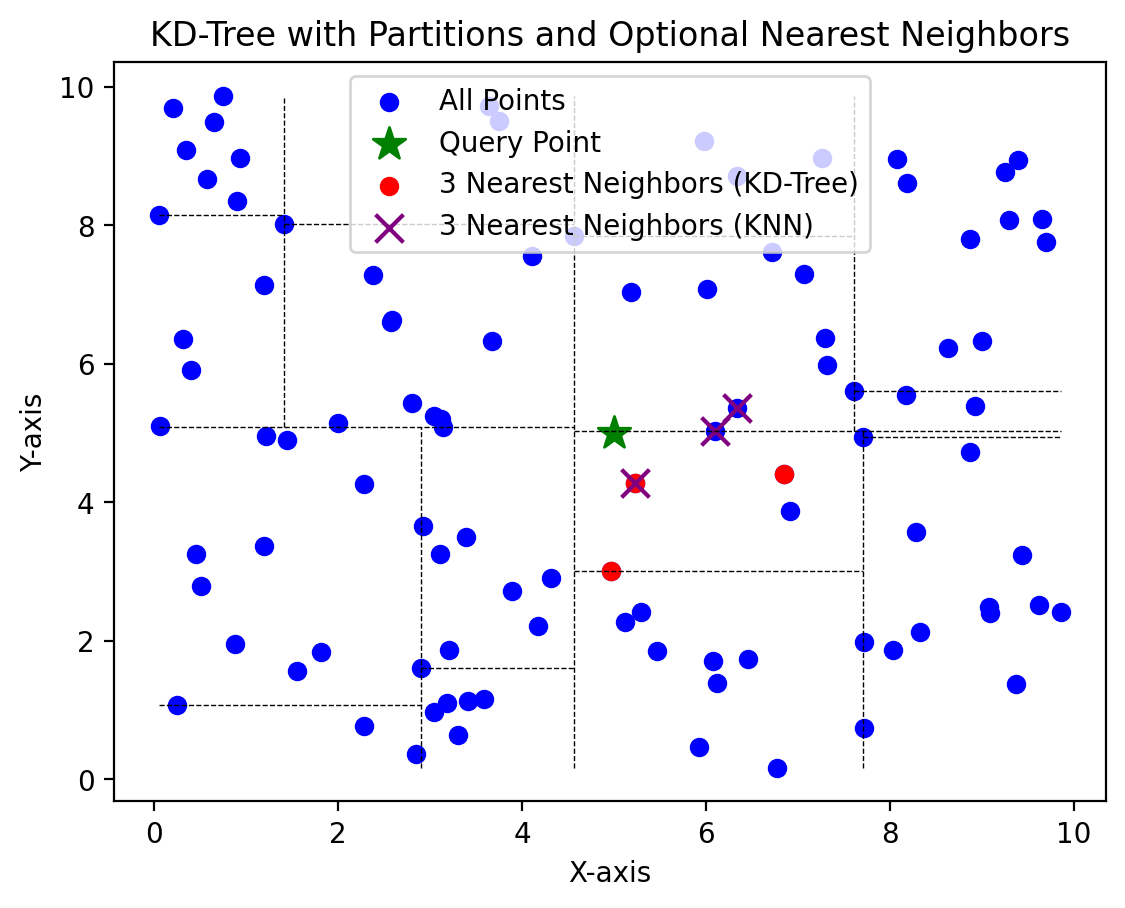

In [17]:
tree = KDTree(min_samples_split=20)
tree.build(X)

query_point = np.array([5, 5])
k = 3
tree.plot_tree(query_point=query_point, k=k)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class LSH:
    def __init__(self, k, L, D):
        """
        Initialize the LSH instance.
        
        Parameters:
        - k: number of neighbors to search for
        - L: number of hash tables
        - D: number of dimensions of the data
        """
        self.k = k  # Number of neighbors
        self.L = L  # Number of hash tables
        self.D = D  # Number of dimensions of the data
        self.hash_tables = [defaultdict(list) for _ in range(L)]
        self.r = 10  # Number of random projections in each hash function
        self.random_projections = [
            np.random.randn(self.D, self.r) for _ in range(L)
        ]  # Random projections for all hash tables
    
    def _hash_function(self, point, table_idx):
        """
        Apply locality-sensitive hashing to a point.
        
        Parameters:
        - point: the data point (as a vector)
        - table_idx: index of the hash table
        
        Returns:
        - A hash value (binary string)
        """
        random_projection = self.random_projections[table_idx]
        hash_value = "".join(
            '1' if np.dot(point, random_projection[:, i]) >= 0 else '0'
            for i in range(self.r)
        )
        return hash_value
    
    def fit(self, X):
        """
        Build the hash tables for the dataset X.
        
        Parameters:
        - X: numpy array of shape (N, D) where N is the number of points and D is the number of dimensions.
        """
        self.X = X
        self.hash_values = [[] for _ in range(self.L)]
        for i in range(self.L):
            for idx, point in enumerate(X):
                hash_value = self._hash_function(point, i)
                self.hash_tables[i][hash_value].append(idx)
                self.hash_values[i].append(hash_value)
    
    def query(self, query_point):
        """
        Find the k nearest neighbors of a query point using LSH.
        
        Parameters:
        - query_point: the point to query (numpy array of shape (D,))
        
        Returns:
        - A list of indices of the nearest neighbors
        """
        candidate_neighbors = set()
        for i in range(self.L):
            hash_value = self._hash_function(query_point, i)
            candidate_neighbors.update(self.hash_tables[i].get(hash_value, []))
        return list(candidate_neighbors)[:self.k]
    
    def plot_partitions(self):
        """
        Plot the partitions in 2D space based on the hash values.
        Different colors represent different partitions.
        """
        if self.X.shape[1] != 2:
            raise ValueError("Plotting is only supported for 2D data.")

        color_map = {}
        unique_hashes = set(hash_val for table in self.hash_values for hash_val in table)
        colors = plt.cm.tab20.colors  # Access a colormap
        
        # Assign a unique color to each hash value
        for idx, hash_value in enumerate(unique_hashes):
            color_map[hash_value] = colors[idx % len(colors)]

        # Plot the points colored by their hash value
        plt.figure(figsize=(8, 6))
        for i, table_hashes in enumerate(self.hash_values):
            for idx, hash_value in enumerate(table_hashes):
                plt.scatter(
                    self.X[idx, 0], self.X[idx, 1],
                    color=color_map[hash_value],
                    alpha=0.6
                )

        plt.title("2D Visualization of LSH Partitions")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.show()
    
    def plot_partitions_with_hyperplanes(self):
        """
        Plot the partitions in 2D space based on the hash values and visualize random hyperplanes.
        Different colors represent different partitions, and dashed lines represent the hyperplanes.
        """
        if self.X.shape[1] != 2:
            raise ValueError("Plotting is only supported for 2D data.")

        plt.figure(figsize=(8, 6))
        # Plot the data points
        for idx, point in enumerate(self.X):
            plt.scatter(point[0], point[1], color='gray', alpha=0.6, label='Data Points')

        # Overlay the random hyperplanes from one table
        random_projection = self.random_projections[0]
        for i in range(self.r):
            projection = random_projection[:, i]
            
            if projection[1] != 0:  # Avoid vertical lines where slope would be infinite
                x = np.linspace(0, 1, 100)
                y = -(projection[0] / projection[1]) * x
                plt.plot(x, y, linestyle='--', color='black', alpha=0.7, label=f'Hyperplane {i+1}')
            else:  # Vertical line case
                x = np.full(100, -projection[0] / 1e-6)  # Small divisor to approximate vertical
                y = np.linspace(0, 1, 100)
                plt.plot(x, y, linestyle='--', color='black', alpha=0.7, label=f'Hyperplane {i+1}')

        plt.title("2D LSH Partitions with Random Hyperplanes")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.show()
        
    def plot_lsh_decision_boundary(lsh, X, labels, grid_step=0.01):
        """
        Visualizes LSH decision boundaries for 2D data.
        
        Parameters:
            lsh: LSH instance with trained hash functions.
            X: Original data points (Nx2 array).
            labels: Labels or cluster IDs for the data points (Nx1 array).
            grid_step: Resolution of the grid for boundary visualization.
        """
        # Define the grid over the range of X
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                            np.arange(y_min, y_max, grid_step))
        
        # Flatten the grid for processing
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        
        # Assign each grid point to an LSH bucket by calling _hash_function
        grid_buckets = []
        for p in grid_points:
            # For each grid point, compute the hash for all hash tables
            bucket = []
            for table_idx in range(lsh.L):  # Use valid table indices (0 to L-1)
                hash_value = lsh._hash_function(p, table_idx)
                bucket.append(hash_value)
            grid_buckets.append(tuple(bucket))  # Store the combined hash values
        grid_buckets = np.array(grid_buckets)
        
        # Map unique buckets to unique indices
        unique_buckets, bucket_indices = np.unique(grid_buckets, axis=0, return_inverse=True)
        
        # Reshape the indices to match the grid
        zz = bucket_indices.reshape(xx.shape)
        
        # Plot the decision boundary
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, zz, cmap='Pastel2', alpha=0.5)  # Fill regions with colors
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Dark2', edgecolor='k')  # Original points
        plt.title("LSH Decision Boundaries")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.show()


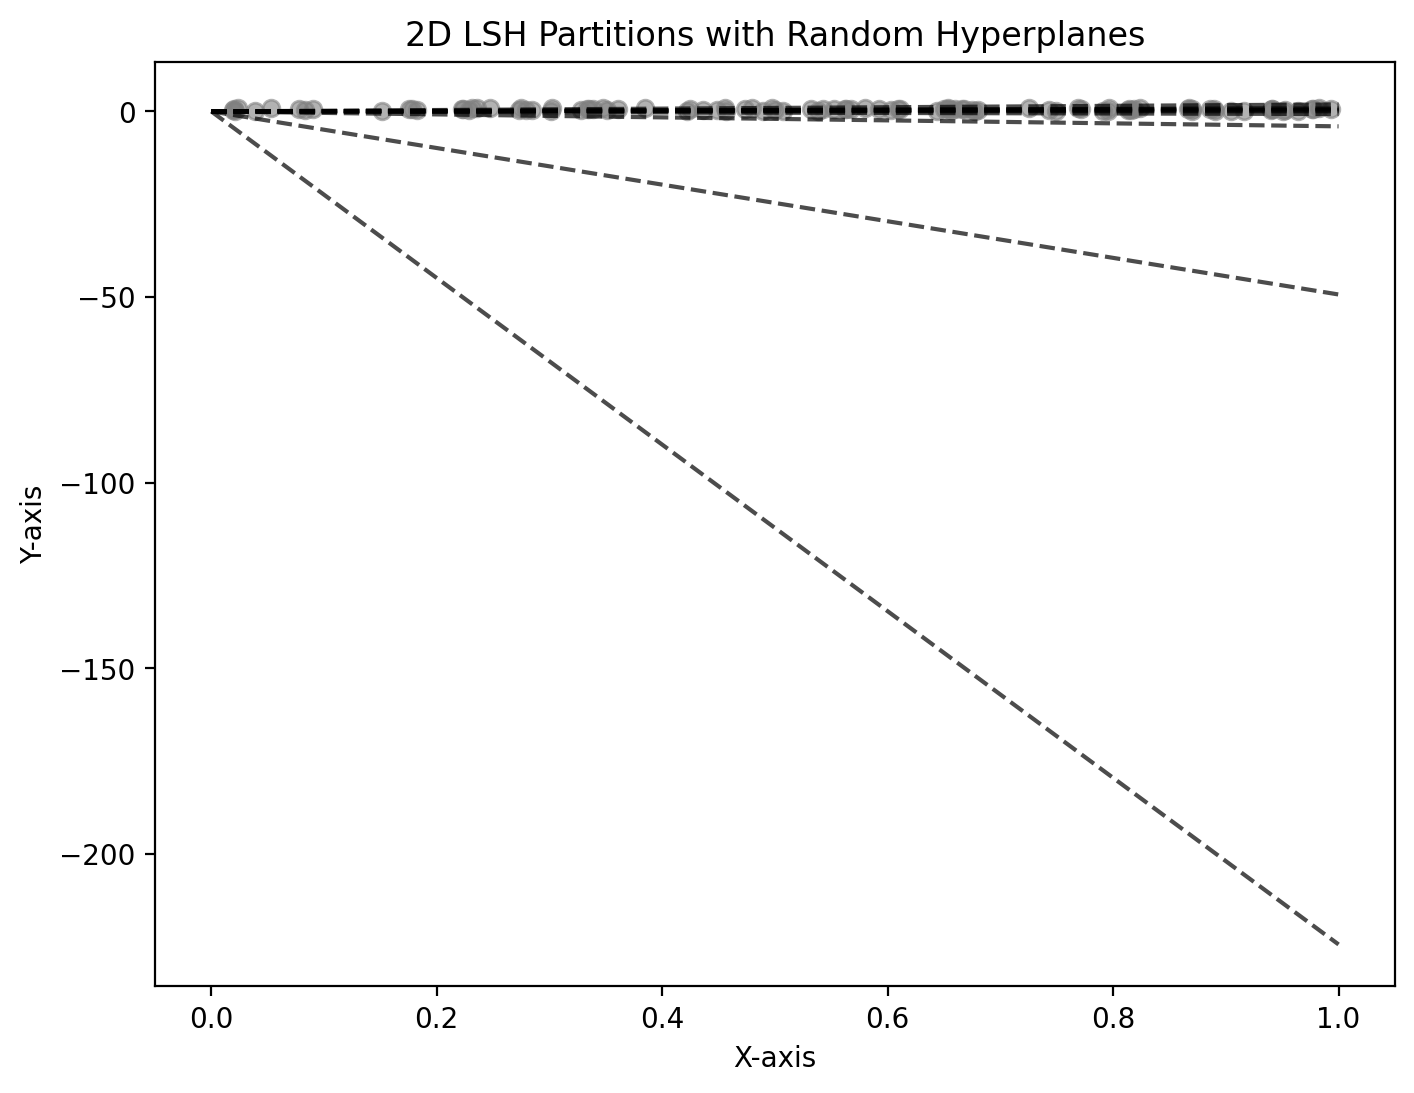

In [73]:
X = np.random.rand(100, 2) 
lsh = LSH(k=5, L=2, D=2)
lsh.fit(X)
lsh.plot_partitions_with_hyperplanes()

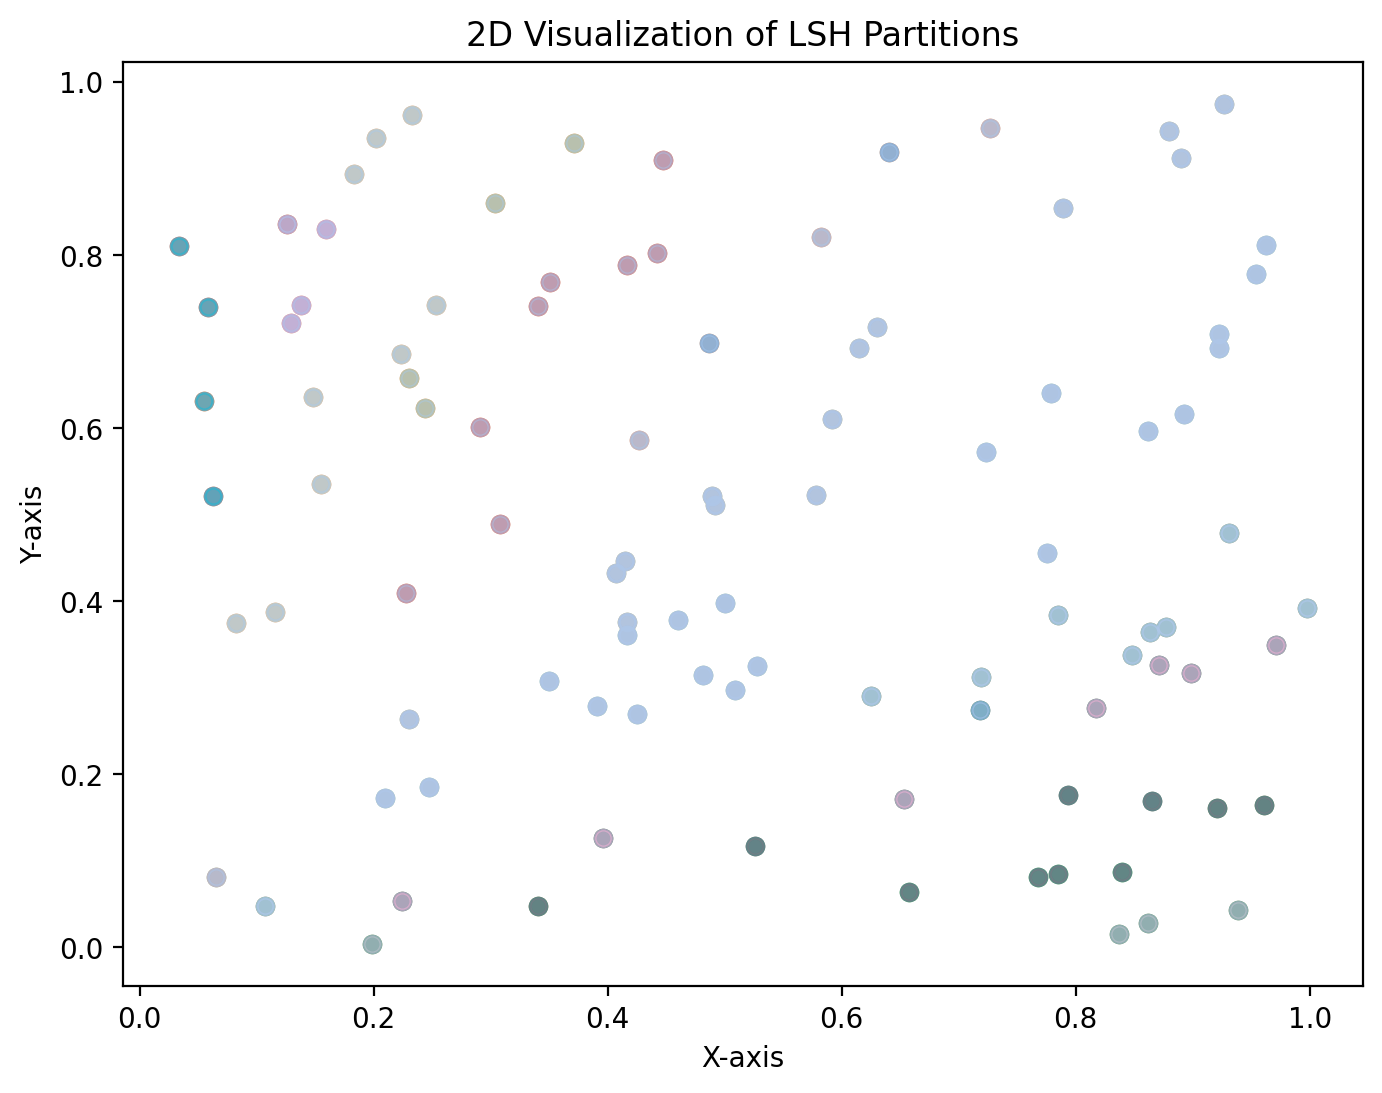

In [71]:
lsh.plot_partitions()

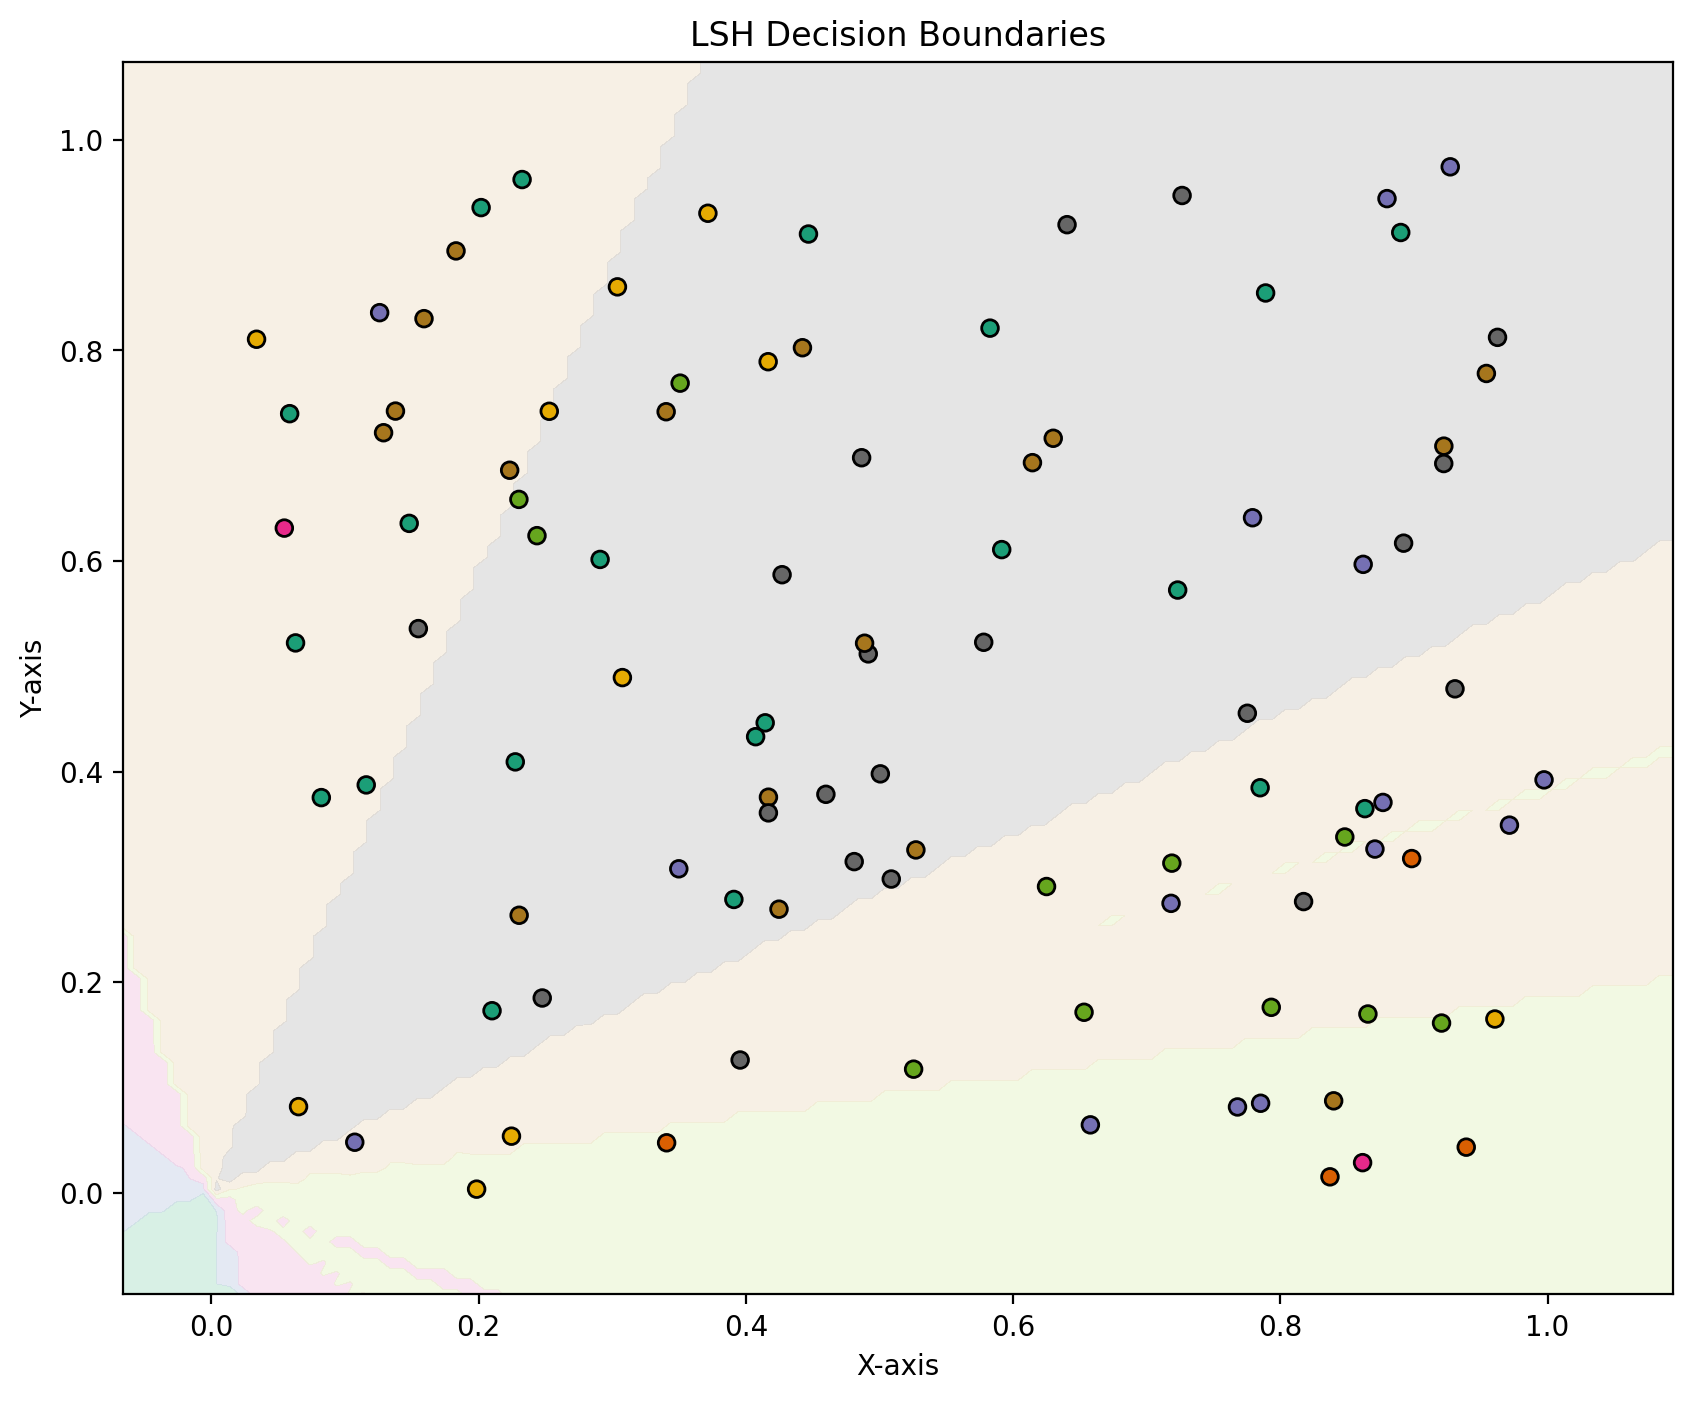

In [72]:
# Fix: Loop over the hash tables, not the data points.
labels = np.array([tuple(lsh._hash_function(p, i % lsh.L)) for i, p in enumerate(X)])

# Then, use np.unique to get unique labels
_, labels = np.unique(labels, axis=0, return_inverse=True)

# Finally, call the plot function with the correct labels
lsh.plot_lsh_decision_boundary(X, labels)


Processing Naive KNN for N=100...
Processing KD-tree for N=100...
Processing LSH for N=100...
Processing Naive KNN for N=500...
Processing KD-tree for N=500...
Processing LSH for N=500...
Processing Naive KNN for N=1000...
Processing KD-tree for N=1000...
Processing LSH for N=1000...
Processing Naive KNN for N=5000...
Processing KD-tree for N=5000...
Processing LSH for N=5000...
Processing Naive KNN for N=10000...
Processing KD-tree for N=10000...
Processing LSH for N=10000...
Processing Naive KNN for N=100000...
Processing KD-tree for N=100000...
Processing LSH for N=100000...
Processing Naive KNN for N=500000...
Processing KD-tree for N=500000...
Processing LSH for N=500000...
Processing Naive KNN for N=1000000...
Processing KD-tree for N=1000000...
Processing LSH for N=1000000...


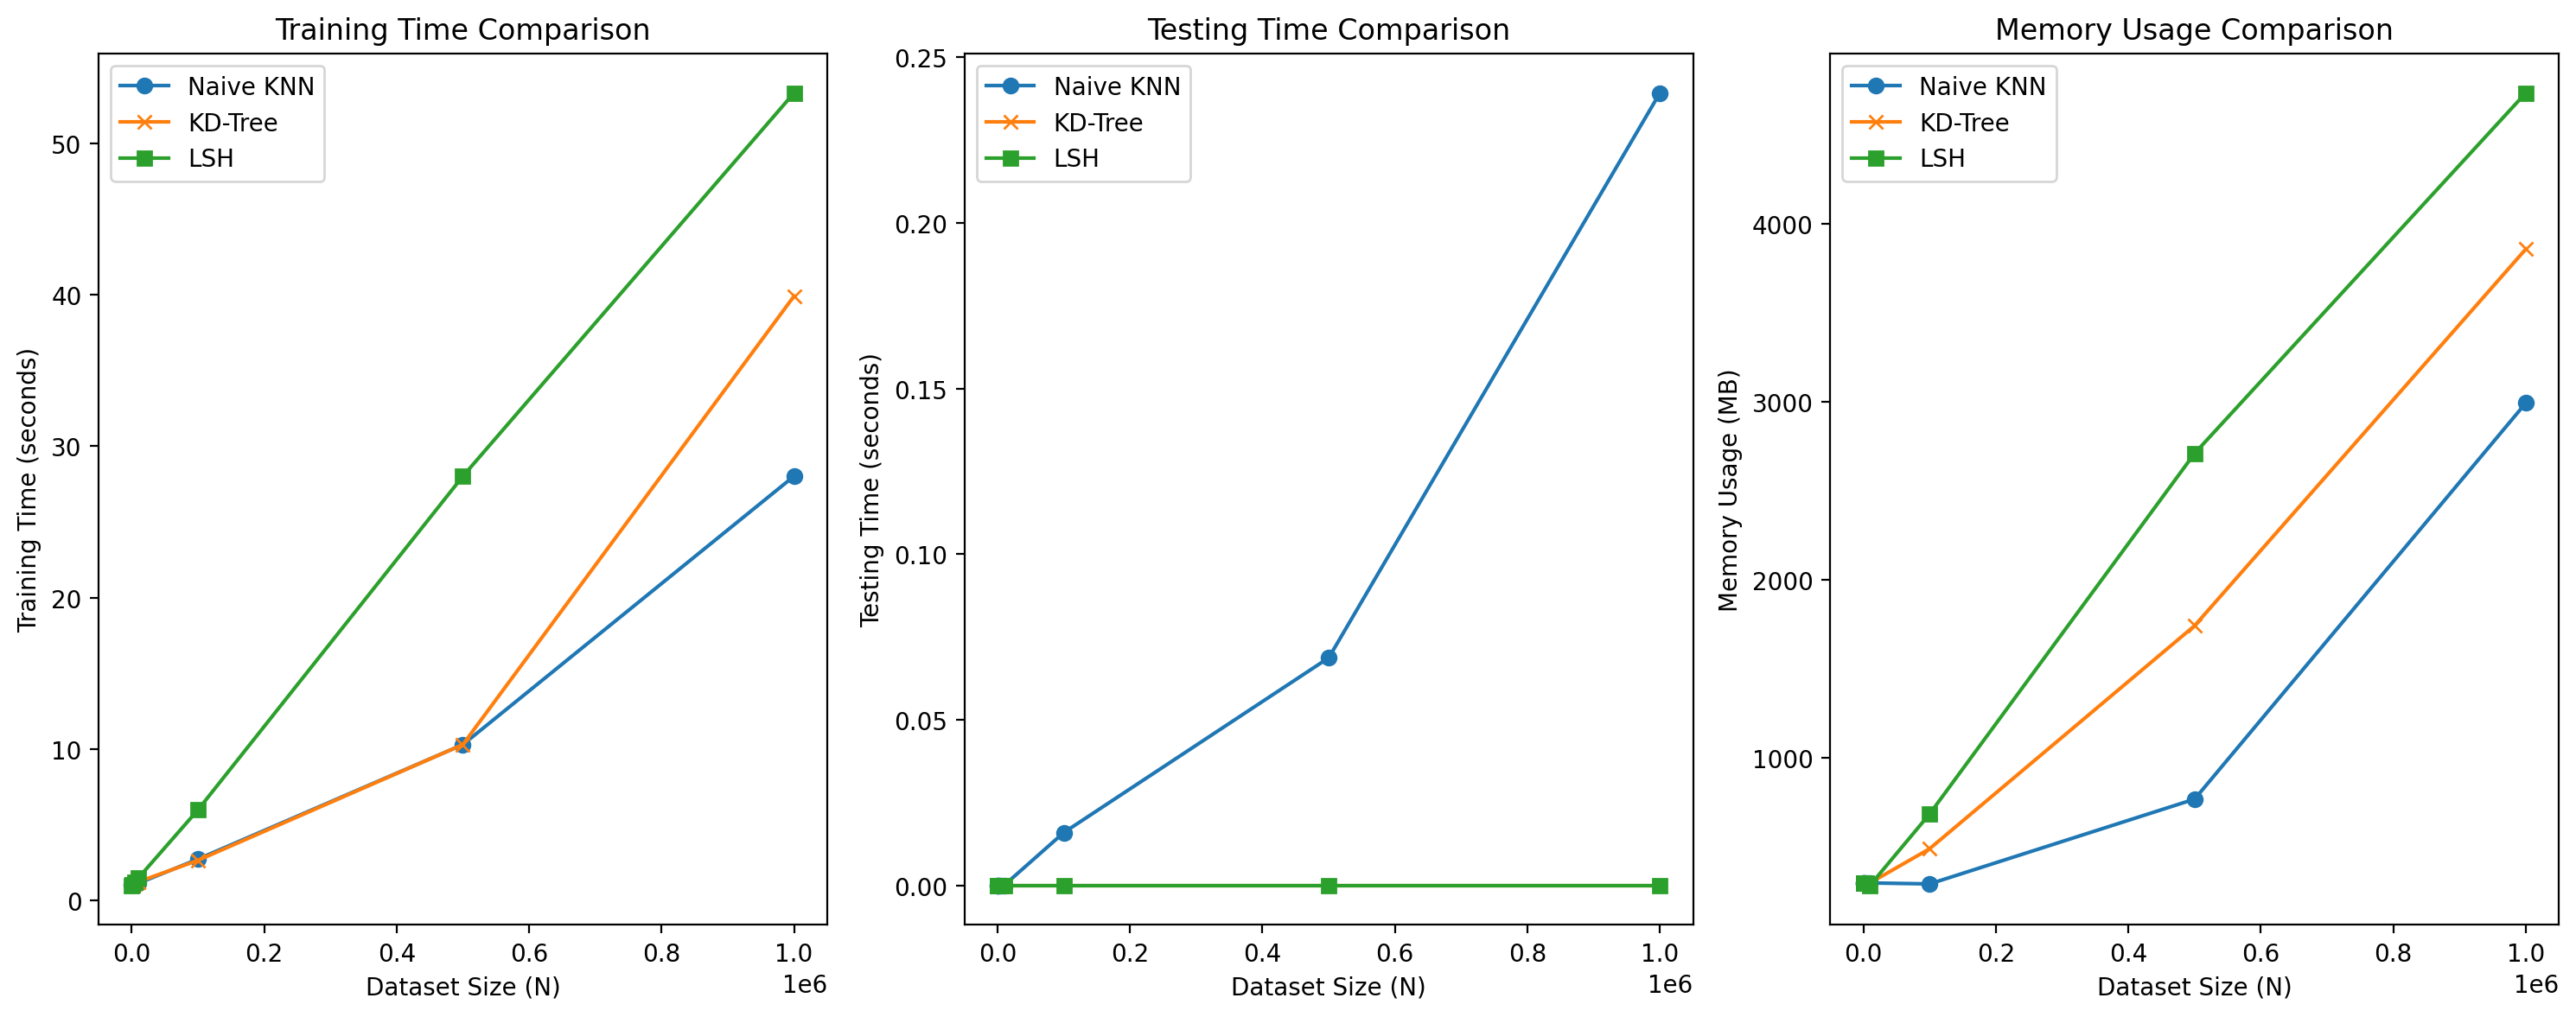

In [ ]:
import time
import memory_profiler
import numpy as np
import matplotlib.pyplot as plt

def compare_knn_methods(N_values, D):
    times_naive_train = []
    times_naive_test = []
    memory_naive = []
    
    times_kdtree_train = []
    times_kdtree_test = []
    memory_kdtree = []
    
    times_lsh_train = []
    times_lsh_test = []
    memory_lsh = []
    
    for N in N_values:
        # Generate random data
        X = np.random.rand(N, D)
        
        # Naive KNN
        print(f"Processing Naive KNN for N={N}...")
        start_time = time.time()
        memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
        knn = KDTree()
        knn.fit(X)
        naive_train_time = time.time() - start_time
        naive_memory = memory_usage
        
        start_time = time.time()
        knn.knn_naive(X[0], 3)
        naive_test_time = time.time() - start_time
        
        times_naive_train.append(naive_train_time)
        times_naive_test.append(naive_test_time)
        memory_naive.append(naive_memory)
        
        # KD-tree
        print(f"Processing KD-tree for N={N}...")
        start_time = time.time()
        memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
        kd_tree = KDTree()
        kd_tree.build(X)
        kd_train_time = time.time() - start_time
        kd_memory = memory_usage
        
        start_time = time.time()
        kd_tree.k_nearest(X[0], 3)
        kd_test_time = time.time() - start_time
        
        times_kdtree_train.append(kd_train_time)
        times_kdtree_test.append(kd_test_time)
        memory_kdtree.append(kd_memory)
        
        # LSH
        print(f"Processing LSH for N={N}...")
        start_time = time.time()
        memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
        lsh = LSH(k=3, L=5, D=D)
        lsh.fit(X)
        lsh_train_time = time.time() - start_time
        lsh_memory = memory_usage
        
        start_time = time.time()
        lsh.query(X[0])
        lsh_test_time = time.time() - start_time
        
        times_lsh_train.append(lsh_train_time)
        times_lsh_test.append(lsh_test_time)
        memory_lsh.append(lsh_memory)

    # Plot the results
    plt.figure(figsize=(15, 6))

    # Plot training times
    plt.subplot(1, 3, 1)
    plt.plot(N_values, times_naive_train, label="Naive KNN", marker='o')
    plt.plot(N_values, times_kdtree_train, label="KD-Tree", marker='x')
    plt.plot(N_values, times_lsh_train, label="LSH", marker='s')
    plt.xlabel('Dataset Size (N)')
    plt.ylabel('Training Time (seconds)')
    plt.legend()
    plt.title("Training Time Comparison")

    # Plot testing times
    plt.subplot(1, 3, 2)
    plt.plot(N_values, times_naive_test, label="Naive KNN", marker='o')
    plt.plot(N_values, times_kdtree_test, label="KD-Tree", marker='x')
    plt.plot(N_values, times_lsh_test, label="LSH", marker='s')
    plt.xlabel('Dataset Size (N)')
    plt.ylabel('Testing Time (seconds)')
    plt.legend()
    plt.title("Testing Time Comparison")

    # Plot memory usage
    plt.subplot(1, 3, 3)
    plt.plot(N_values, memory_naive, label="Naive KNN", marker='o')
    plt.plot(N_values, memory_kdtree, label="KD-Tree", marker='x')
    plt.plot(N_values, memory_lsh, label="LSH", marker='s')
    plt.xlabel('Dataset Size (N)')
    plt.ylabel('Memory Usage (MB)')
    plt.legend()
    plt.title("Memory Usage Comparison")

    plt.tight_layout()
    plt.show()

N_values = [100, 500, 1000, 5000, 10000, 100000, 500000, 1000000]  # Varying dataset sizes
D = 10  
compare_knn_methods(N_values, D)


In [ ]:
import time
import memory_profiler
import numpy as np

def compare_knn_methods_specific(N, D):
    X = np.random.rand(N, D)
    
    # Naive KNN
    print(f"\nNaive KNN for N={N}, D={D}:")
    start_time = time.time()
    memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
    knn = KDTree()
    knn.fit(X)
    naive_train_time = time.time() - start_time
    naive_memory = memory_usage
    
    start_time = time.time()
    knn.knn_naive(X[0], 3)
    naive_test_time = time.time() - start_time
    print(f"Naive KNN - Train time: {naive_train_time:.4f}s, Test time: {naive_test_time:.4f}s, Memory: {naive_memory:.2f} MB")
    
    # KD-tree
    print(f"\nKD-tree for N={N}, D={D}:")
    start_time = time.time()
    memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
    kd_tree = KDTree()
    kd_tree.build(X)
    kd_train_time = time.time() - start_time
    kd_memory = memory_usage
    
    start_time = time.time()
    kd_tree.k_nearest(X[0], 3)
    kd_test_time = time.time() - start_time
    print(f"KD-tree - Train time: {kd_train_time:.4f}s, Test time: {kd_test_time:.4f}s, Memory: {kd_memory:.2f} MB")
    
    # LSH
    print(f"\nLSH for N={N}, D={D}:")
    start_time = time.time()
    memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
    lsh = LSH(k=3, L=5, D=D)
    lsh.fit(X)
    lsh_train_time = time.time() - start_time
    lsh_memory = memory_usage
    
    start_time = time.time()
    lsh.query(X[0])
    lsh_test_time = time.time() - start_time
    print(f"LSH - Train time: {lsh_train_time:.4f}s, Test time: {lsh_test_time:.4f}s, Memory: {lsh_memory:.2f} MB")

N = 100000  # Number of data points
D = 10  # Number of dimensions
compare_knn_methods_specific(N, D)



Naive KNN for N=100000, D=10:
Naive KNN - Train time: 2.7324s, Test time: 0.0130s, Memory: 287.28 MB

KD-tree for N=100000, D=10:
KD-tree - Train time: 2.7656s, Test time: 0.0000s, Memory: 438.15 MB

LSH for N=100000, D=10:
LSH - Train time: 12.4706s, Test time: 0.0000s, Memory: 612.46 MB



Naive KNN for N=100000, D=2:

KD-tree for N=100000, D=2:

LSH for N=100000, D=2:

Naive KNN for N=100000, D=25:

KD-tree for N=100000, D=25:

LSH for N=100000, D=25:

Naive KNN for N=100000, D=100:

KD-tree for N=100000, D=100:

LSH for N=100000, D=100:

Naive KNN for N=100000, D=500:

KD-tree for N=100000, D=500:

LSH for N=100000, D=500:

Naive KNN for N=100000, D=1000:

KD-tree for N=100000, D=1000:

LSH for N=100000, D=1000:


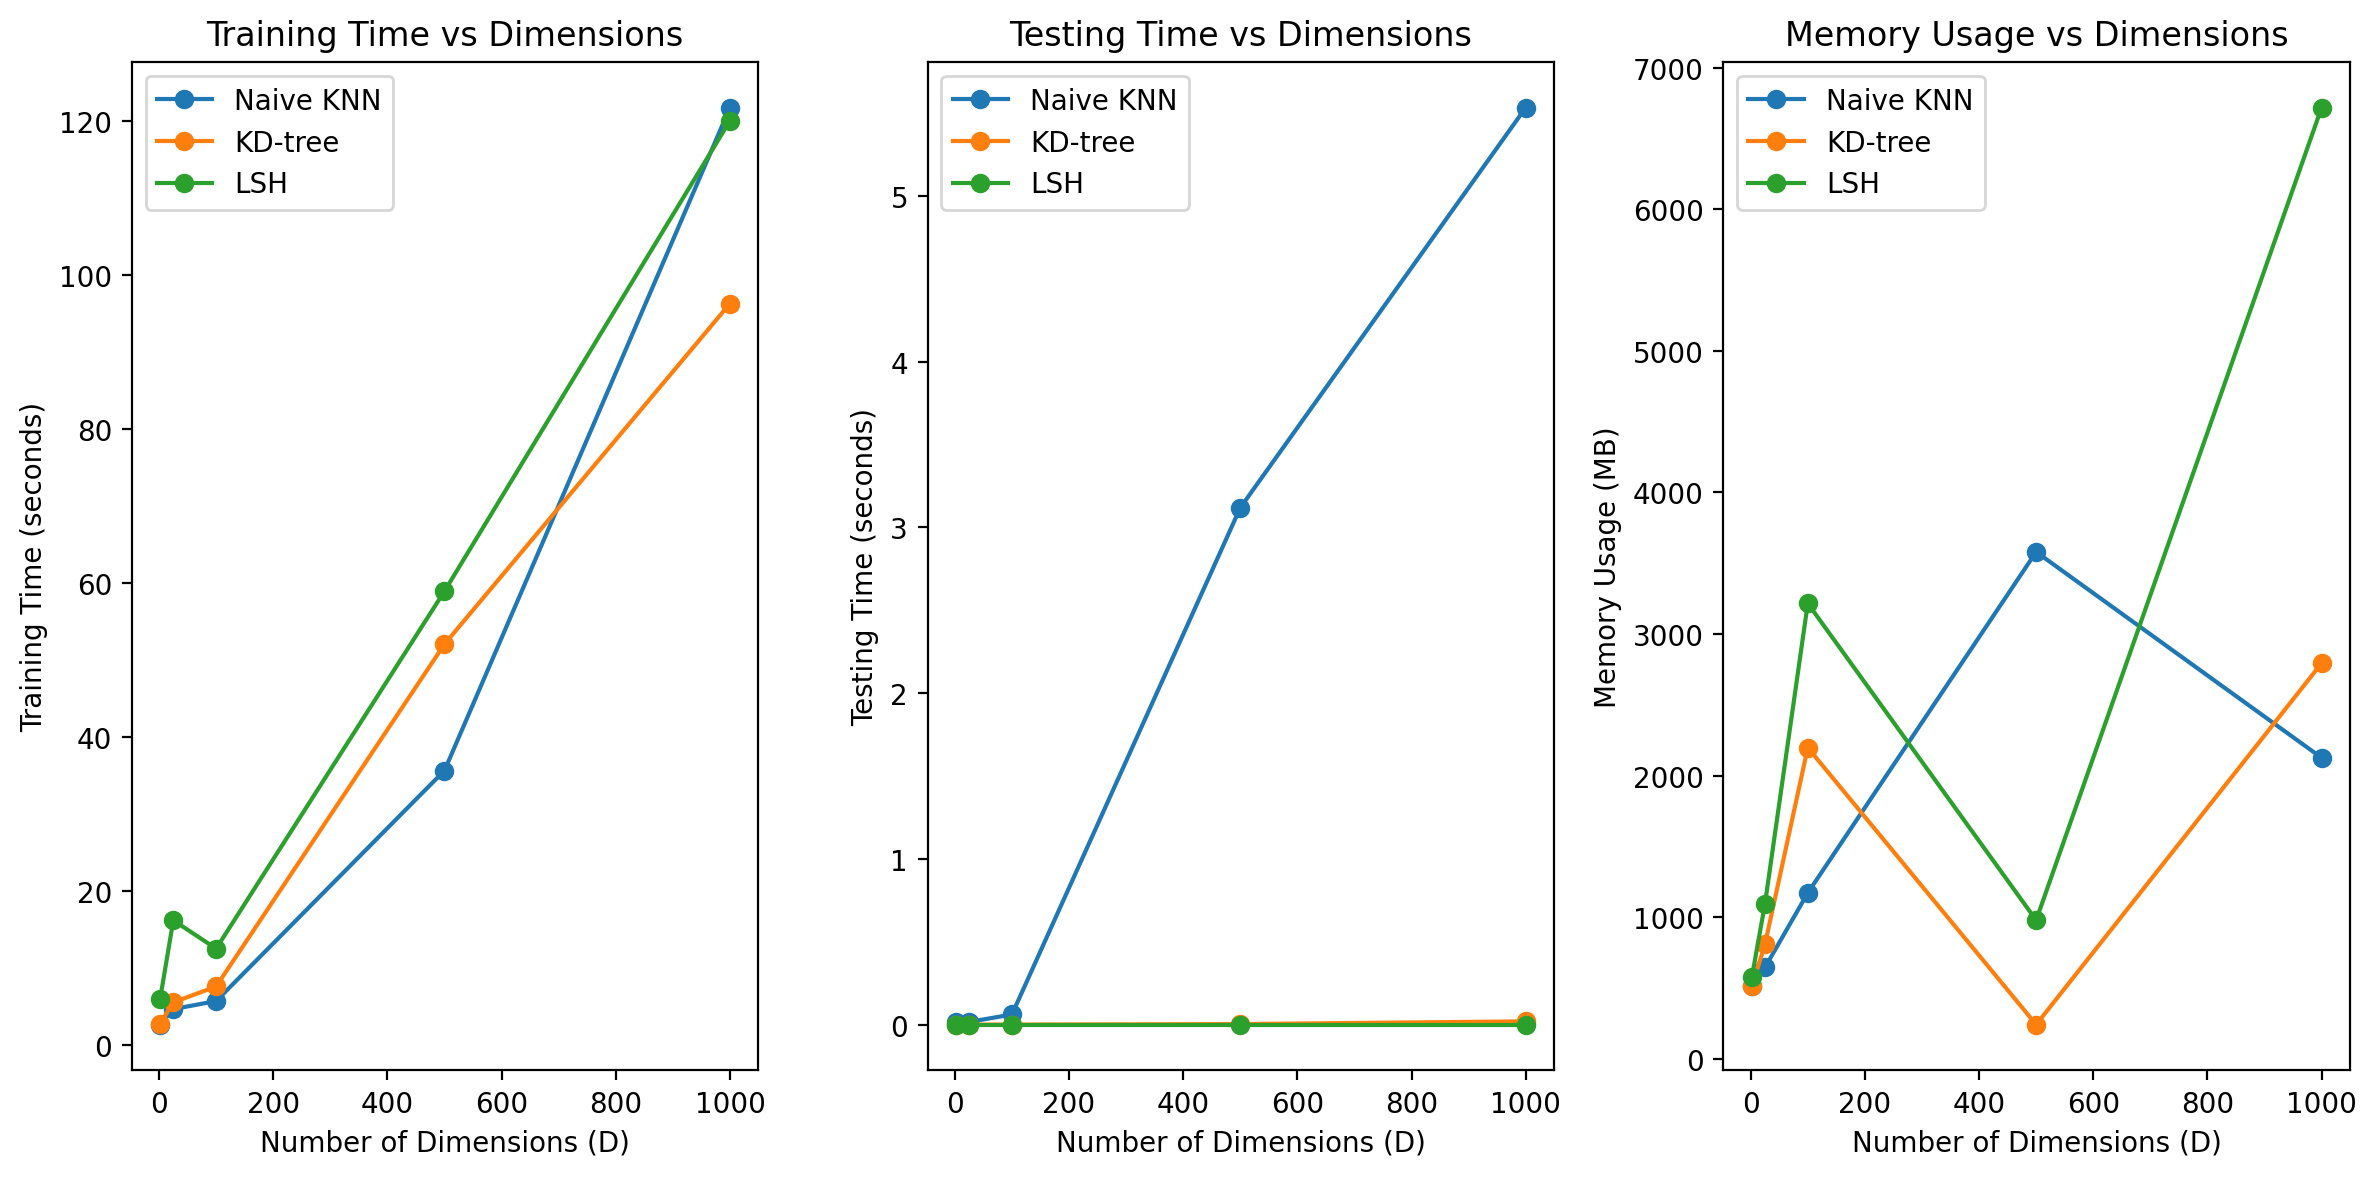

In [ ]:
import time
import memory_profiler
import numpy as np
import matplotlib.pyplot as plt

def compare_knn_methods_vary_D(N, D_values):
    train_times_naive = []
    test_times_naive = []
    memory_naive = []
    
    train_times_kdtree = []
    test_times_kdtree = []
    memory_kdtree = []
    
    train_times_lsh = []
    test_times_lsh = []
    memory_lsh = []
    
    for D in D_values:
        X = np.random.rand(N, D)
        
        # Naive KNN
        print(f"\nNaive KNN for N={N}, D={D}:")
        start_time = time.time()
        memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
        knn = KDTree()
        knn.fit(X)
        naive_train_time = time.time() - start_time
        naive_memory = memory_usage
        
        start_time = time.time()
        knn.knn_naive(X[0], 3)
        naive_test_time = time.time() - start_time
        train_times_naive.append(naive_train_time)
        test_times_naive.append(naive_test_time)
        memory_naive.append(naive_memory)
        
        # KD-tree
        print(f"\nKD-tree for N={N}, D={D}:")
        start_time = time.time()
        memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
        kd_tree = KDTree()
        kd_tree.build(X)
        kd_train_time = time.time() - start_time
        kd_memory = memory_usage
        
        start_time = time.time()
        kd_tree.k_nearest(X[0], 3)
        kd_test_time = time.time() - start_time
        train_times_kdtree.append(kd_train_time)
        test_times_kdtree.append(kd_test_time)
        memory_kdtree.append(kd_memory)
        
        # LSH
        print(f"\nLSH for N={N}, D={D}:")
        start_time = time.time()
        memory_usage = memory_profiler.memory_usage(proc=-1, interval=0.1, timeout=1)[0]
        lsh = LSH(k=3, L=5, D=D)
        lsh.fit(X)
        lsh_train_time = time.time() - start_time
        lsh_memory = memory_usage
        
        start_time = time.time()
        lsh.query(X[0])
        lsh_test_time = time.time() - start_time
        train_times_lsh.append(lsh_train_time)
        test_times_lsh.append(lsh_test_time)
        memory_lsh.append(lsh_memory)

    plt.figure(figsize=(12, 6))

    # Plot train times
    plt.subplot(1, 3, 1)
    plt.plot(D_values, train_times_naive, label="Naive KNN", marker='o')
    plt.plot(D_values, train_times_kdtree, label="KD-tree", marker='o')
    plt.plot(D_values, train_times_lsh, label="LSH", marker='o')
    plt.xlabel("Number of Dimensions (D)")
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time vs Dimensions")
    plt.legend()

    # Plot test times
    plt.subplot(1, 3, 2)
    plt.plot(D_values, test_times_naive, label="Naive KNN", marker='o')
    plt.plot(D_values, test_times_kdtree, label="KD-tree", marker='o')
    plt.plot(D_values, test_times_lsh, label="LSH", marker='o')
    plt.xlabel("Number of Dimensions (D)")
    plt.ylabel("Testing Time (seconds)")
    plt.title("Testing Time vs Dimensions")
    plt.legend()

    # Plot memory usage
    plt.subplot(1, 3, 3)
    plt.plot(D_values, memory_naive, label="Naive KNN", marker='o')
    plt.plot(D_values, memory_kdtree, label="KD-tree", marker='o')
    plt.plot(D_values, memory_lsh, label="LSH", marker='o')
    plt.xlabel("Number of Dimensions (D)")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory Usage vs Dimensions")
    plt.legend()

    plt.tight_layout()
    plt.show()

N = 100000  # Number of data points
D_values = [2, 25, 100, 500, 1000]  # Different values of D (dimensions)
compare_knn_methods_vary_D(N, D_values)
